In [1]:
from numpy import *

In [2]:
# 加载数据集
def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float, curLine))
        dataMat.append(fltLine)
    return dataMat

# 计算欧氏距离
def distEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

# 为给定数据集构建一个包含k个随机质心的集合
def randCent(dataSet, k):
    n = shape(dataSet)[1]  # 特征数
    centroids = mat(zeros((k, n)))
    for j in range(n):
        minJ = min(dataSet[:, j])
        rangeJ = float(max(dataSet[:, j]) - minJ)
        centroids[:, j] = minJ + rangeJ * random.rand(k, 1)
    return centroids

In [3]:
datMat = mat(loadDataSet('testSet.txt'))

In [4]:
random.rand(2, 1)  # 生成2行1列的0~1随机数

array([[0.40559433],
       [0.2498449 ]])

In [5]:
distEclud(datMat[0], datMat[1])

5.184632816681332

In [6]:
randCent(datMat, 2)

matrix([[ 1.2826327 ,  1.11125099],
        [ 4.48949359, -1.28938167]])

In [7]:
def kMeans(dataSet, k, distMeans=distEclud, createCent=randCent):
    m = shape(dataSet)[0]  # 数据数量
    clusterAssment = mat(zeros((m, 2)))  # 记录距离最近的簇点序号及距离
    centroids = createCent(dataSet, k)  # 创建k组随机簇点
    clusterChanged = True  # 标记是否发送改变
    while clusterChanged:
        clusterChanged = False
        for i in range(m):  # 遍历每一条数据
            minDist = inf
            minIndex = -1
            for j in range(k):  # 遍历每一个簇点
                distJI = distMeans(centroids[j, :], dataSet[i, :])  # 到每个簇点的距离
                if distJI < minDist:
                    minDist = distJI
                    minIndex = j
            if clusterAssment[i, 0] != minIndex:  # 距离最近的簇点发生了改变
                clusterChanged = True
            clusterAssment[i, :] = minIndex, minDist**2  # 更新最近簇点序号和距离
#         print(centroids)  # 输出簇点值
        
        # 求取每个簇点所包含的数据点，并取均值保存该簇点信息
        for cent in range(k):  # 遍历每一个簇点
            ptsInClust = dataSet[nonzero(clusterAssment[:, 0].A == cent)[0]]
            centroids[cent, :] = mean(ptsInClust, axis=0)  # 将属于该簇点的数据集取均值
    return centroids, clusterAssment

In [8]:
datMat = mat(loadDataSet('testSet.txt'))
myCentroids, clustAssing = kMeans(datMat, 4)

In [9]:
myCentroids

matrix([[-3.38237045, -2.9473363 ],
        [-2.46154315,  2.78737555],
        [ 2.80293085, -2.7315146 ],
        [ 2.6265299 ,  3.10868015]])

In [10]:
# 自定义绘图
def MyScatter(datMat, myCentroids):
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(list(datMat[:,0]), list(datMat[:,1]), s=30, c='green', marker='s')
    ax.scatter(list(myCentroids[:, 0]), list(myCentroids[:, 1]), s=30, c='red')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

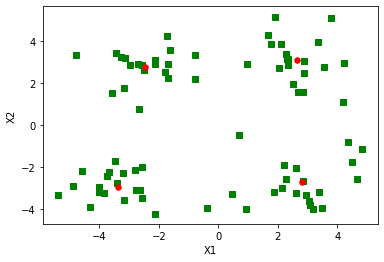

In [11]:
MyScatter(datMat, myCentroids)

### 二分k-均值算法

In [12]:
def biKmeans(dataSet, k, distMeans=distEclud):
    m = shape(dataSet)[0]  # 数据数量
    clusterAssment = mat(zeros((m, 2)))  # 每个数据点所在簇序号和距离（平方）
    
    centroid0 = mean(dataSet, axis=0).tolist()[0]  # 初始族0
    centList = [centroid0]  # 保存所有的簇信息
    
    for j in range(m):
        clusterAssment[j, 1] = distMeans(mat(centroid0), dataSet[j, :])**2
        
    while len(centList) < k:
        lowestSSE = inf
        for i in range(len(centList)):  # 遍历每一个簇
            # 属于簇 i 的所有数据集
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:, 0].A == i)[0], :]
            # 将该簇二分为两个簇
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeans)
            # 计算划分后所有簇的距离和
            sseSplit = sum(splitClustAss[:, 1])
            # 计算不划分时所有簇的距离和
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:, 0].A != i)[0], 1])
            print('sseSplit, and notSplit: ', sseSplit, sseNotSplit)
            
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i  # 记录最好的划分簇序号
                bestNewCents = centroidMat  # 记录此方式划分后的簇信息
                bestClustAss = splitClustAss.copy()  # 记录此划分每个数据点到簇的信息
                lowestSSE = sseSplit + sseNotSplit  # 更新最小SSE值
        
        # 更新划分簇后数据点的簇序号信息
        bestClustAss[nonzero(bestClustAss[:, 0].A == 1)[0], 0] = len(centList)
        bestClustAss[nonzero(bestClustAss[:, 0].A == 0)[0], 0] = bestCentToSplit
        print('the bestCentToSplit is: ', bestCentToSplit)
        print('the len of bestClutAss is: ', len(bestClustAss))
        
        # 加入原划分的簇信息
        centList[bestCentToSplit] = bestNewCents[0, :]
        # 加入新划分出来的簇信息
        centList.append(bestNewCents[1, :])
        
        # 更新划分簇后数据点的簇距离信息
        clusterAssment[nonzero(clusterAssment[:, 0].A == bestCentToSplit)[0], :] = \
                                                                     bestClustAss
    
    _centList = []  # 对数据格式进行修改方便输出
    for i in centList:
        _centList.append(i.tolist()[0])
    return mat(_centList), clusterAssment

In [13]:
datMat3 = mat(loadDataSet('testSet2.txt'))
centList, myNewAssments = biKmeans(datMat3, 3)

sseSplit, and notSplit:  453.0334895807502 0.0
the bestCentToSplit is:  0
the len of bestClutAss is:  60
sseSplit, and notSplit:  12.753263136887313 423.8762401366249
sseSplit, and notSplit:  77.59224931775066 29.15724944412535
the bestCentToSplit is:  1
the len of bestClutAss is:  40


In [14]:
centList

matrix([[-0.45965615, -2.7782156 ],
        [ 2.93386365,  3.12782785],
        [-2.94737575,  3.3263781 ]])

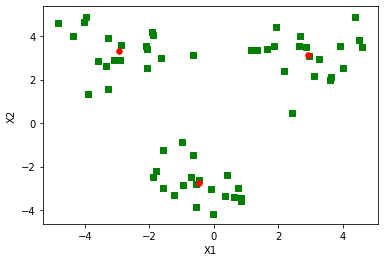

In [15]:
MyScatter(datMat3, centList)

## 实例：对地图上的点进行聚类

In [31]:
# 利用球面余弦定理求地球两点间距离（英里）
def distSLC(vecA, vecB):
    a = sin(vecA[0, 1] * pi / 180) * sin(vecB[0, 1] * pi / 180)
    b = cos(vecA[0, 1] * pi / 180) * cos(vecB[0, 1] * pi / 180) * \
        cos(pi * (vecB[0, 0] - vecA[0 ,0]) / 180)
    return arccos(a + b) * 6371.0

import matplotlib.pyplot as plt
# 将俱乐部聚类并画出结果
def clusterClubs(numClust=5):
    datList = []
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = mat(datList)
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeans=distSLC)
    
    fig = plt.figure()
    rect = [0.1, 0.1, 0.8, 0.8]
    scatterMarkers = ['s', 'o', '^', '8', 'p', 'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0 = fig.add_axes(rect, label='ax0', **axprops)
    imgP = plt.imread('Portland.png')
    ax0.imshow(imgP)
    ax1 = fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[nonzero(clustAssing[:, 0].A == i)[0], :]
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:, 0].flatten().A[0], \
                   ptsInCurrCluster[:, 1].flatten().A[0], \
                   marker=markerStyle, s=90)
    ax1.scatter(myCentroids[:, 0].flatten().A[0], \
                myCentroids[:, 1].flatten().A[0], \
                marker='+', s=300)
    plt.show()

sseSplit, and notSplit:  3043.263316150597 0.0
the bestCentToSplit is:  0
the len of bestClutAss is:  69
sseSplit, and notSplit:  511.8065376456885 2191.824427550861
sseSplit, and notSplit:  1441.2311748306158 851.4388885997361
the bestCentToSplit is:  1
the len of bestClutAss is:  39
sseSplit, and notSplit:  505.6196082286877 1441.2311748306158
sseSplit, and notSplit:  136.45217645464223 2055.024222084809
sseSplit, and notSplit:  734.2228349073521 1089.0847299452792
the bestCentToSplit is:  2
the len of bestClutAss is:  30
sseSplit, and notSplit:  505.6196082286877 971.8686762528952
sseSplit, and notSplit:  166.81275720428226 1585.6617235070883
sseSplit, and notSplit:  75.19223028633219 1655.3711593709252
sseSplit, and notSplit:  119.45148829956294 1257.0211354269854
the bestCentToSplit is:  3
the len of bestClutAss is:  24


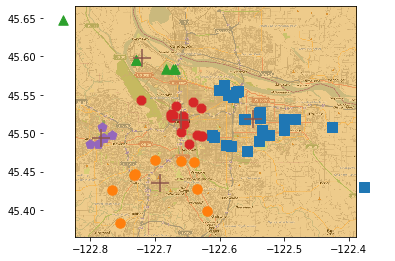

In [32]:
clusterClubs(5)